In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [2]:
# Load the dataset
data = pd.read_csv("card_transdata.csv")

In [3]:
# Load top 5 from dataset
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
# Split the data into features (X) and the target variable (y)
X = data.drop("fraud", axis=1)
y = data["fraud"]

In [5]:
# Split the data into training and testing sets with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
# Data Preprocessing: Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [7]:
# Create a Random Forest model
rf_model = RandomForestClassifier(random_state=42)

When you run this, it should take about 10 minutes to complete. The progress bar (still working on it) does not update, but you will get printed out updates as it goes.

In [8]:
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Create a tqdm progress bar
with tqdm(total=len(param_grid['n_estimators']) * len(param_grid['max_depth']) *
              len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf'])) as pbar:
    def update_pbar(*args):
        pbar.update()

    # Create a GridSearchCV instance
    grid_search = GridSearchCV(rf_model, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=10)
    grid_search.n_iter = np.prod([len(v) for v in param_grid.values()])
    grid_search._run_search(update_pbar)
    
# Perform grid search for hyperparameter tuning
grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  22 out of  48 | elapsed:  5.7min remaining:  6.7min
[Parallel(n_jobs=-1)]: Done  27 out of  48 | elapsed:  5.9min remaining:  4.6min
[Parallel(n_jobs=-1)]: Done  32 out of  48 | elapsed:  7.6min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  37 out of  48 | elapsed:  7.7min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  42 out of  48 | elapsed:  7.9min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  9.1min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='roc_auc', verbose=10)

In [9]:
print("Best Parameters: ", grid_search.best_params_)
print("Best ROC AUC Score: ", grid_search.best_score_)

Best Parameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best ROC AUC Score:  0.9999999989421705


In [10]:
# Get the best model
best_rf_model = grid_search.best_estimator_

In [11]:
# Evaluate the best model
y_pred_rf = best_rf_model.predict(X_test)

In [12]:
# Evaluation Metrics for Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)

In [13]:
# Display Results for Random Forest
print("Random Forest Model Metrics:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")
print(f"ROC AUC: {roc_auc_rf}")

Random Forest Model Metrics:
Accuracy: 0.999975
Precision: 1.0
Recall: 0.999713975173045
F1 Score: 0.9998569671310468
ROC AUC: 0.9998569875865225


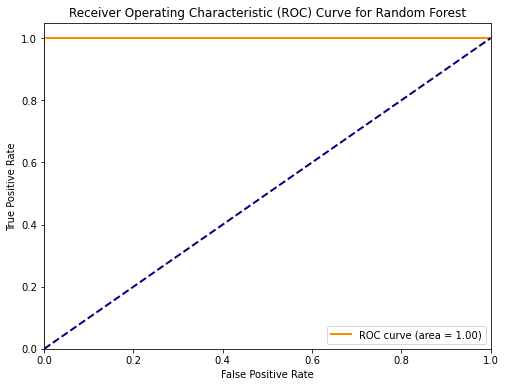

In [14]:
# Plot ROC Curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:,1])
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.show()

In [33]:
import numpy as np
import pandas as pd

# Set a random seed for reproducibility
np.random.seed(42)

# Number of synthetic data points
num_samples = 1000

# Create synthetic data for each feature
data = {
    'distance_from_home': np.random.normal(30, 10, num_samples),
    'distance_from_last_transaction': np.random.normal(1.0, 1.0, num_samples),
    'ratio_to_median_purchase_price': np.random.normal(1.0, 0.5, num_samples),
    'repeat_retailer': np.random.choice([0, 1], num_samples),
    'used_chip': np.random.choice([0, 1], num_samples),
    'used_pin_number': np.random.choice([0, 1], num_samples),
    'online_order': np.random.choice([0, 1], num_samples),
    'fraud': np.random.choice([0, 1], num_samples)
}

# Create a synthetic dataset
synthetic_df = pd.DataFrame(data)

# Split the synthetic data into features (X) and the target variable (y)
X = synthetic_df.drop("fraud", axis=1)
y = synthetic_df["fraud"]

# Display the first few rows of the synthetic dataset
synthetic_df.head()



,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,34.967142,2.399355,0.662411,1,1,0,1,1
1,28.617357,1.924634,0.927741,1,1,1,1,0
2,36.476885,1.059630,0.603790,1,0,0,0,0
3,45.230299,0.353063,0.846019,1,0,0,1,1
4,27.658466,1.698223,0.053193,0,1,1,0,0


In [34]:
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train your model on the synthetic data (X, y)
rf_model.fit(X, y)

RandomForestClassifier(random_state=42)

In [39]:
# Make predictions on the same data
y_pred = rf_model.predict(X)

# Calculate evaluation metrics on the synthetic data
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)

In [42]:
# Display Results for Random Forest
print("Random Forest Model Metrics on Synthetic Data:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

Random Forest Model Metrics on Synthetic Data:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0


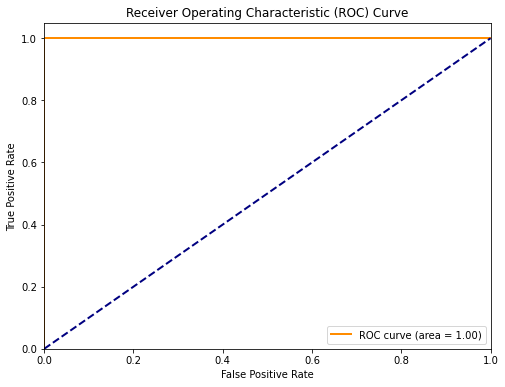

In [43]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y, rf_model.predict_proba(X)[:, 1])

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y, rf_model.predict_proba(X)[:, 1])

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
how to stop false negative.
